In [1]:
import geopandas as gpd
import pandas as pd

## Lectura de los archivos necesarios

In [2]:
#Shapefile descargado de https://opendata.esri.es/datasets/53229f5912e04f1ba6dddb70a5abeb72_0/explore?location=38.266512%2C-3.478376%2C6.34
municipios = gpd.read_file("../data/municipios/Municipios_IGN.shp")

In [3]:
municipios.head(2)

,FID,INSPIREID,NATCODE,NAMEUNIT,CODNUT1,CODNUT2,CODNUT3,CODIGOINE,SHAPE_Leng,SHAPE_Area,geometry
0,1,ES.IGN.SIGLIM34081616266,34081616266,Villarejo-Periesteban,ES4,ES42,ES423,16266,0.269748,0.003520,"POLYGON ((-2.47791 39.88027, -2.47793 39.88074..."
1,2,ES.IGN.SIGLIM34081616269,34081616269,Villares del Saz,ES4,ES42,ES423,16269,0.447608,0.007382,"POLYGON ((-2.58669 39.85793, -2.58601 39.85842..."


<Axes: >

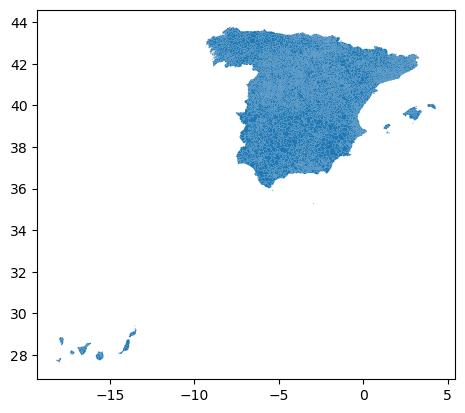

In [4]:
municipios.plot()

In [5]:
#Archivo de AEITG: https://aei.turismo.gal/osdam/filestore/5/0/1/9/4_893e1d06b8baeab/50194_c06f838949eab20.csv
xeodestinos = pd.read_excel("../data/Excel_Xeodestinos.xls")
xeodestinos = xeodestinos[["Codigo Concello", "Nome Xeodestino"]]
xeodestinos.rename(columns={"Codigo Concello": "municipioID", "Nome Xeodestino": "area"}, inplace=True)

## Agrupación de los municipios en áreas

In [6]:
agrupaciones_gdf = gpd.GeoDataFrame(columns=['nombre', 'geometry'])

In [7]:
agrupaciones = list()
for i in xeodestinos.area.unique():
    agrupaciones.append({"nombre": i, "municipios": [str(j) for j in list(xeodestinos[xeodestinos.area == i].municipioID.array)]})


### Fusión del mapa por área

In [8]:
for agrupacion in agrupaciones:
    municipios_fusionados = municipios[municipios['CODIGOINE'].isin(agrupacion['municipios'])]
    union_geom = municipios_fusionados.unary_union
    #agrupaciones_gdf = agrupaciones_gdf.append(}, ignore_index=True)
    agrupaciones_gdf = pd.concat([agrupaciones_gdf, pd.DataFrame({'nombre': agrupacion['nombre'], 'geometry': union_geom}, index=[0])], ignore_index=True)

<Axes: >

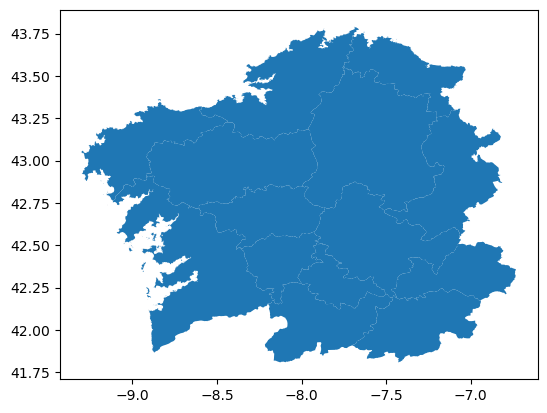

In [9]:
agrupaciones_gdf.plot()

### Seteo el crs

In [10]:
agrupaciones_gdf = agrupaciones_gdf.set_crs(municipios.crs)

In [11]:
agrupaciones_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

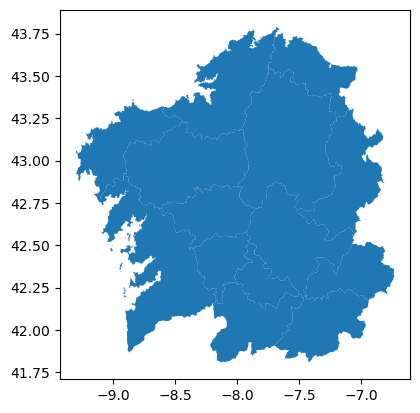

In [12]:
agrupaciones_gdf.plot()

In [13]:
agrupaciones_gdf.to_file('../out/shapefile/AreasTuristicas.shp', driver='ESRI Shapefile', always_xy=True)

## Exportación a topojson (para PowerBI)

In [ ]:
import topojson as tp
import json

# Convierte el GeoDataFrame a un diccionario TopoJSON
topojson_dict = tp.Topology(agrupaciones_gdf, topology=True).to_dict()

# Guarda el diccionario TopoJSON en un archivo TopoJSON
with open('../out/topojson/AreasTuristicas.json', 'w') as topojson_file:
    json.dump(topojson_dict, topojson_file)